In [1]:
import numpy as np
import tsfresh
from tsfresh.feature_extraction import ComprehensiveFCParameters
from matplotlib import pyplot as plt
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, precision_score, recall_score

In [4]:
# Далее в коде понадобятся для обработки массивов
def to_tsfresh_type(train:np.array,
                    window_size:int,
                    test:np.array=None, 
                    mask:np.array=None):
    # Нарезка рядов со скользящих окном
    train_with_windows = sliding_window_view(train, window_size)
    test_with_windows = sliding_window_view(test.reshape(-1), window_size)
    mask_with_windows = sliding_window_view(mask.reshape(-1), window_size)
    # Приведене к формату pandas, ибо tsfresh работает с ним
    train_with_windows_tsfresh = pd.DataFrame({
        'id':np.arange(1, len(train_with_windows) + 1).repeat(window_size),
        'time': np.tile(np.arange(1, window_size + 1), len(train_with_windows)),
        'value':train_with_windows.reshape(-1)})

    test_with_windows_tsfresh = pd.DataFrame({
        'id':np.arange(1, len(test_with_windows) + 1).repeat(window_size),
        'time': np.tile(np.arange(1, window_size + 1), len(test_with_windows)),
        'value':test_with_windows.reshape(-1)})
    return train_with_windows_tsfresh, test_with_windows_tsfresh, mask_with_windows

def get_ts_feature(train_with_windows_tsfresh:pd.DataFrame,
                   test_with_windows_tsfresh:pd.DataFrame,
                   column_id = 'id',
                   column_sort = 'time',
                   column_value = 'value',
                   kind_to_fc_parameters = None
                   ):
    if kind_to_fc_parameters == None:
        # Список статистик по умолчанию 
        kind_to_fc_parameters = {
            'value': {
                'mean_change': None,          
                'autocorrelation': [{'lag': 3}],  
                'skewness': None,       
                'kurtosis': None,
                'root_mean_square':None,
                'abs_energy': None,
                'change_quantiles': [{'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'mean'}]
            }
        }
    ts_features_train = tsfresh.extract_features(train_with_windows_tsfresh, column_id=column_id, column_sort=column_sort, column_value=column_value,
                                        kind_to_fc_parameters=kind_to_fc_parameters)
    ts_features_test = tsfresh.extract_features(test_with_windows_tsfresh, column_id=column_id, column_sort=column_sort, column_value=column_value,
                                        kind_to_fc_parameters=kind_to_fc_parameters)
    # NaN есть в признаке с автокорреляцией, а точнее в тех окнах ряда, где все значения одинаковые
    # NaN заполняются 0, что бы не ругался IsolationForest
    ts_features_train.fillna(0, inplace=True)
    ts_features_test.fillna(0, inplace=True)
    return ts_features_train, ts_features_test

In [5]:
# Список всех возможных статистих поддерживаемых tsfresh
for key in ComprehensiveFCParameters().keys():
    print(key, ComprehensiveFCParameters()[key])

variance_larger_than_standard_deviation None
has_duplicate_max None
has_duplicate_min None
has_duplicate None
sum_values None
abs_energy None
mean_abs_change None
mean_change None
mean_second_derivative_central None
median None
mean None
length None
standard_deviation None
variation_coefficient None
variance None
skewness None
kurtosis None
root_mean_square None
absolute_sum_of_changes None
longest_strike_below_mean None
longest_strike_above_mean None
count_above_mean None
count_below_mean None
last_location_of_maximum None
first_location_of_maximum None
last_location_of_minimum None
first_location_of_minimum None
percentage_of_reoccurring_values_to_all_values None
percentage_of_reoccurring_datapoints_to_all_datapoints None
sum_of_reoccurring_values None
sum_of_reoccurring_data_points None
ratio_value_number_to_time_series_length None
sample_entropy None
maximum None
absolute_maximum None
minimum None
benford_correlation None
time_reversal_asymmetry_statistic [{'lag': 1}, {'lag': 2}, {

In [6]:
# Загрузка временных рядов
v = 3
mask = np.load(f'dataset/mask/mask{v}.npy')
test = np.load(f'dataset/test/test{v}.npy')
train = np.load(f'dataset/train/train{v}.npy')

print(f"mask shape:{mask.shape}\ntest shape:{test.shape}\ntrain shape:{train.shape}\n")

mask shape:(10, 10080)
test shape:(10, 10080)
train shape:(86400,)



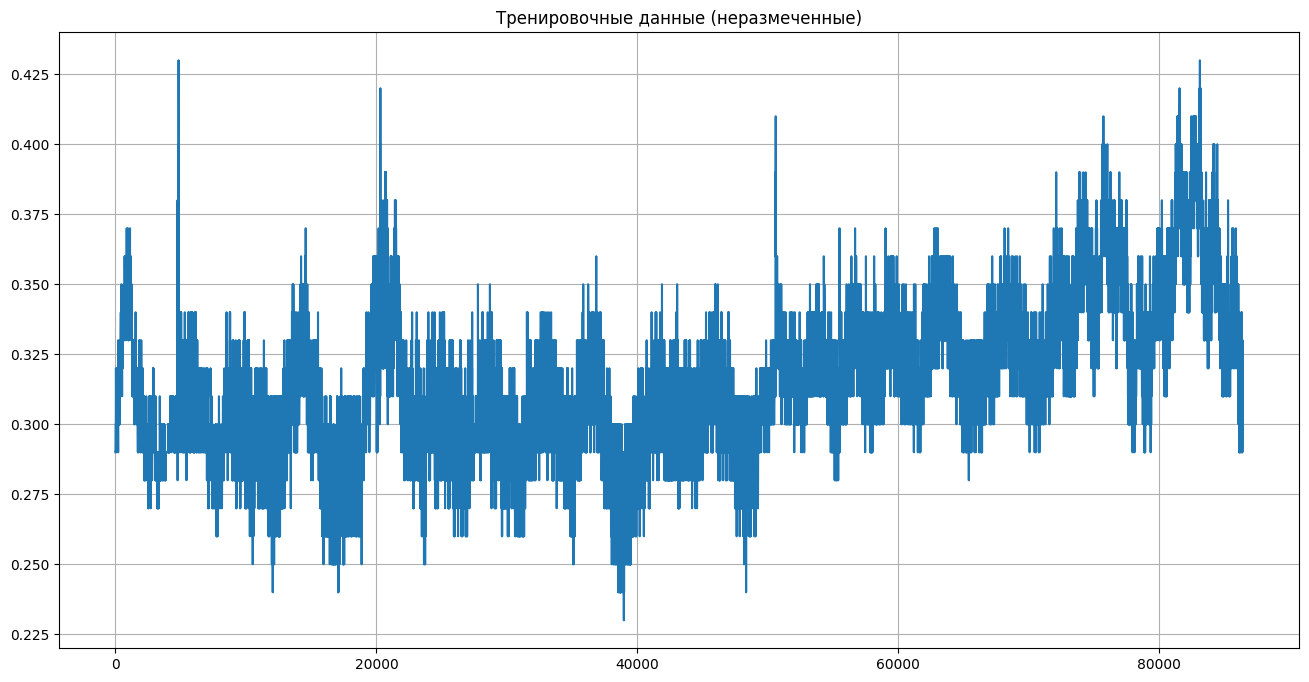

In [7]:
plt.figure(figsize=(16, 8))
plt.plot(train)
plt.grid()
plt.title("Тренировочные данные (неразмеченные)")
plt.show()

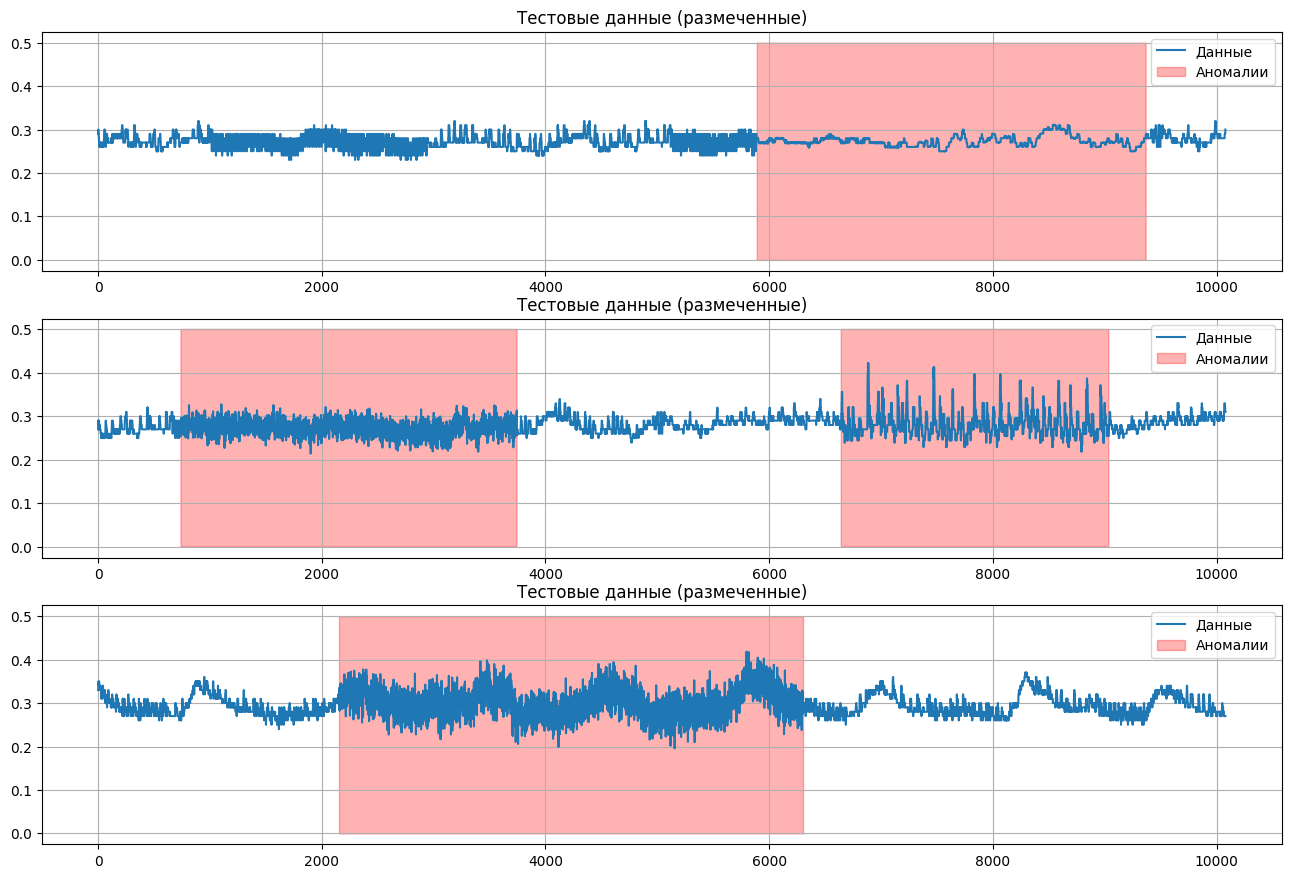

In [8]:
plt.figure(figsize=(16, 18))
for index in range(1, 4):
    plt.subplot(5, 1, index)
    plt.plot(test[index, :10080], label='Данные')
    plt.title("Тестовые данные (размеченные)")
    # Заштриховываем области с аномалиями
    plt.fill_between(
        x=np.arange(len(mask[index, :10080])),  # координаты по оси X
        y1=mask[index, :10080] / 2,           # верхняя граница (например, маска аномалий)
        y2=0,                                 # нижняя граница (нулевая линия)
        where=mask[index, :10080] > 0,        # условие для заштрихования
        color='red',                          # цвет заштрихованной области
        alpha=0.3,                            # прозрачность
        label='Аномалии'
    )
    
    plt.legend()
    plt.grid()

In [9]:
windows_all_size = [50, 75, 100, 125, 150]
precision_array = []
f1_array = []
recall_array = []
model_1_exp = []
for window_size in windows_all_size:
    # to_tsfresh_type нарезает массив скользящми окнами и делает таблицу pandas
    train_with_windows_tsfresh, test_with_windows_tsfresh, mask_with_windows = to_tsfresh_type(train=train, test=test, mask=mask, window_size=window_size)
    # get_ts_feature получает признаки для временного ряда, набор признаков по умолчанию прописал в самой функции
    ts_features_train, ts_features_test = get_ts_feature(train_with_windows_tsfresh, test_with_windows_tsfresh)
    model = IsolationForest(random_state=12312).fit(ts_features_train)
    predict = model.predict(ts_features_test)
    predict[predict == 1] = 0
    predict[predict == -1] = 1
    # Если в окне есть аномалия (1), то метод any выведет те строки где есть хотя бы True (1 то же самое что и True, аналогично 0 == False)
    # Смена типа на int для подсчета метрик
    Y = mask_with_windows.any(axis=1).astype(np.int32)
    precision_array.append(precision_score(Y, predict))
    recall_array.append(recall_score(Y, predict))
    f1_array.append(f1_score(Y, predict))
    model_1_exp.append(model)

Feature Extraction: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


In [12]:
# Статистика по количеству окон с аномалиями для примера с размером окна равным 150
n = np.unique(Y, return_counts=True)
print(f'Общее количество окон: {Y.shape[0]}, ко-во окон с аномалией: {n[1][1]}, {round(n[1][1] / Y.shape[0] * 100, 3)}% от общего числа')
# Acuracy использовать не очень разумно мне кажется, т.к. присутствует дисбаланс

Общее количество окон: 100651, ко-во окон с аномалией: 29810, 29.617% от общего числа


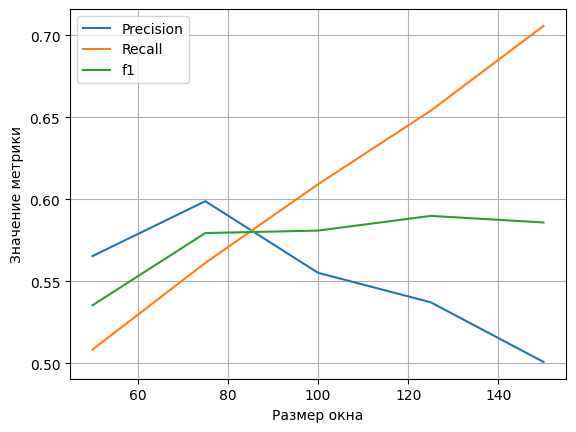

In [13]:
plt.plot(windows_all_size, precision_array, label='Precision')
plt.plot(windows_all_size, recall_array, label='Recall')
plt.plot(windows_all_size, f1_array, label='f1')
plt.xlabel('Размер окна')
plt.ylabel('Значение метрики')
plt.legend()
plt.grid()

In [14]:
# Дополняю список новыми статистиками (подаю как аргумент в функцию get_ts_feature)
kind_to_fc_parameters = {
    'value': {
        'has_duplicate_max':None,
        'has_duplicate_min':None,
        'mean_change': None,        
        'standard_deviation':None,
        'variation_coefficient':None,
        'autocorrelation': [{'lag': 3}],  
        'skewness': None,       
        'kurtosis': None,
        'root_mean_square':None,
        'abs_energy': None,
        'change_quantiles': [{'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'mean'}]
    }
}

In [15]:
windows_all_size = [50, 75, 100, 125, 150]
precision_array = []
f1_array = []
recall_array = []
model_2_exp = []
for window_size in windows_all_size:
    # to_tsfresh_type нарезает массив скользящми окнами и делает таблицу pandas
    train_with_windows_tsfresh, test_with_windows_tsfresh, mask_with_windows = to_tsfresh_type(train=train, test=test, mask=mask, window_size=window_size)
    # get_ts_feature получает признаки для временного ряда, набор признаков по умолчанию прописал в самой функции
    ts_features_train, ts_features_test = get_ts_feature(train_with_windows_tsfresh, test_with_windows_tsfresh, kind_to_fc_parameters=kind_to_fc_parameters)
    model = IsolationForest(random_state=12312).fit(ts_features_train)
    predict = model.predict(ts_features_test)
    predict[predict == 1] = 0
    predict[predict == -1] = 1
    # Если в окне есть аномалия (1), то метод any выведет те строки где есть хотя бы True (1 то же самое что и True, аналогично 0 == False)
    # Смена типа на int для подсчета метрик
    Y = mask_with_windows.any(axis=1).astype(np.int32)
    precision_array.append(precision_score(Y, predict))
    recall_array.append(recall_score(Y, predict))
    f1_array.append(f1_score(Y, predict))
    model_2_exp.append(model)

Feature Extraction: 100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


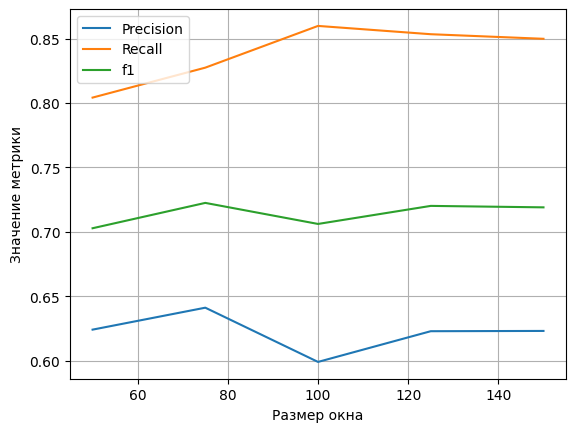

In [17]:
# Видно что при увеличении набора статистик метрики повышаются, в значительной степени это касается recall. 
# На практике же выбор между recall и precision определяется преследуемыми целями
# Если стоит задача детектить все аномалии, не учитывая ложные срабатывания, то выбор в сторону recall.
# Если задача противоположная то precision
# Так же можно заметить что с увеличением количества статистик (признаков для модели) размер окна начинает оказывает меньшее влияние на метрики.
# На 2 графике видно на глаз что дисперсия recall меньше.
# Соответственно для получения высоких значений метрик необходимо делать упор на подбор статистик
plt.plot(windows_all_size, precision_array, label='Precision')
plt.plot(windows_all_size, recall_array, label='Recall')
plt.plot(windows_all_size, f1_array, label='f1')
plt.xlabel('Размер окна')
plt.ylabel('Значение метрики')
plt.legend()
plt.grid()